In [1]:
library(tidyverse)
library(coda)
library(glue)

options(repr.plot.width = 15, repr.plot.height = 8)
theme_set(theme_gray(base_size = 20))


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
samples <- read_csv("experiment_samples.csv") |>
    rename(Iteration = `...1`) |>
    pivot_longer(starts_with("birth_rate"),
        names_to = "Parameter",
        values_to = "Sample"
    ) |>
    mutate(tree = factor(tree))

truth <- tibble(
    Parameter = c("birth_rate1", "birth_rate2"),
    Truth = c(1, 4)
)


New names:
• `` -> `...1`
Rows: 20010 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (7): ...1, tree, birth_rate1, birth_rate2, log_likelihood, log_prior, lo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


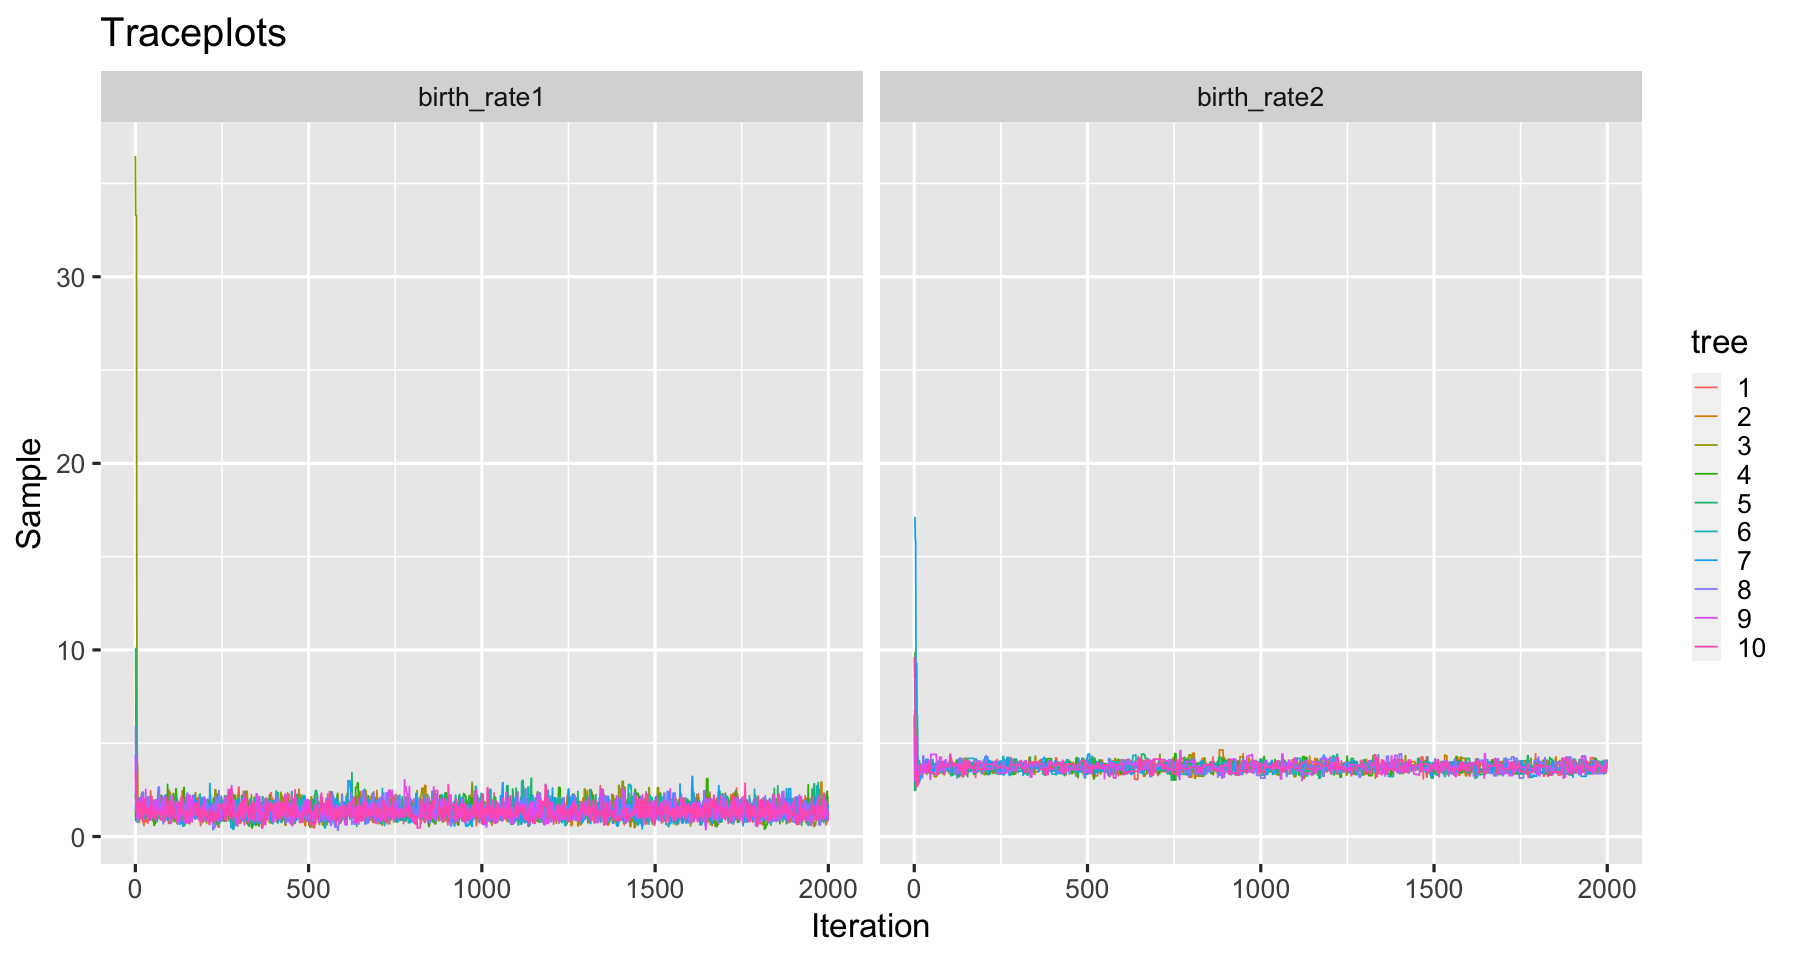

In [3]:
ggplot(samples, aes(Iteration, Sample, color = tree)) +
    geom_line() +
    facet_wrap(vars(Parameter)) +
    ggtitle("Traceplots")


In [4]:
samples |>
    group_by(Parameter, tree) |>
    summarise(
        n = n(),
        ESS = effectiveSize(Sample),
        quantile_025 = quantile(Sample, 0.025),
        median = median(Sample),
        quantile_975 = quantile(Sample, 0.975),
    ) |>
    left_join(truth, by = "Parameter") |>
    mutate(
        `Relative error` = abs((median - Truth) / Truth),
        Coverage = quantile_025 <= Truth & Truth <= quantile_975
    ) |>
    group_by(Parameter) |>
    summarise(
        n = sum(n),
        ESS = sum(ESS) |> round(),
        `Relative error` = mean(`Relative error`),
        Coverage = glue("{100*mean(Coverage)}%")
    )


`summarise()` has grouped output by 'Parameter'. You can override using the
`.groups` argument.


Parameter,n,ESS,Relative error,Coverage
<chr>,<int>,<dbl>,<dbl>,<glue>
birth_rate1,20010,4365,0.33091086,100%
birth_rate2,20010,2697,0.07189495,100%


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 17 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 20 rows containing missing values (`geom_bar()`).”


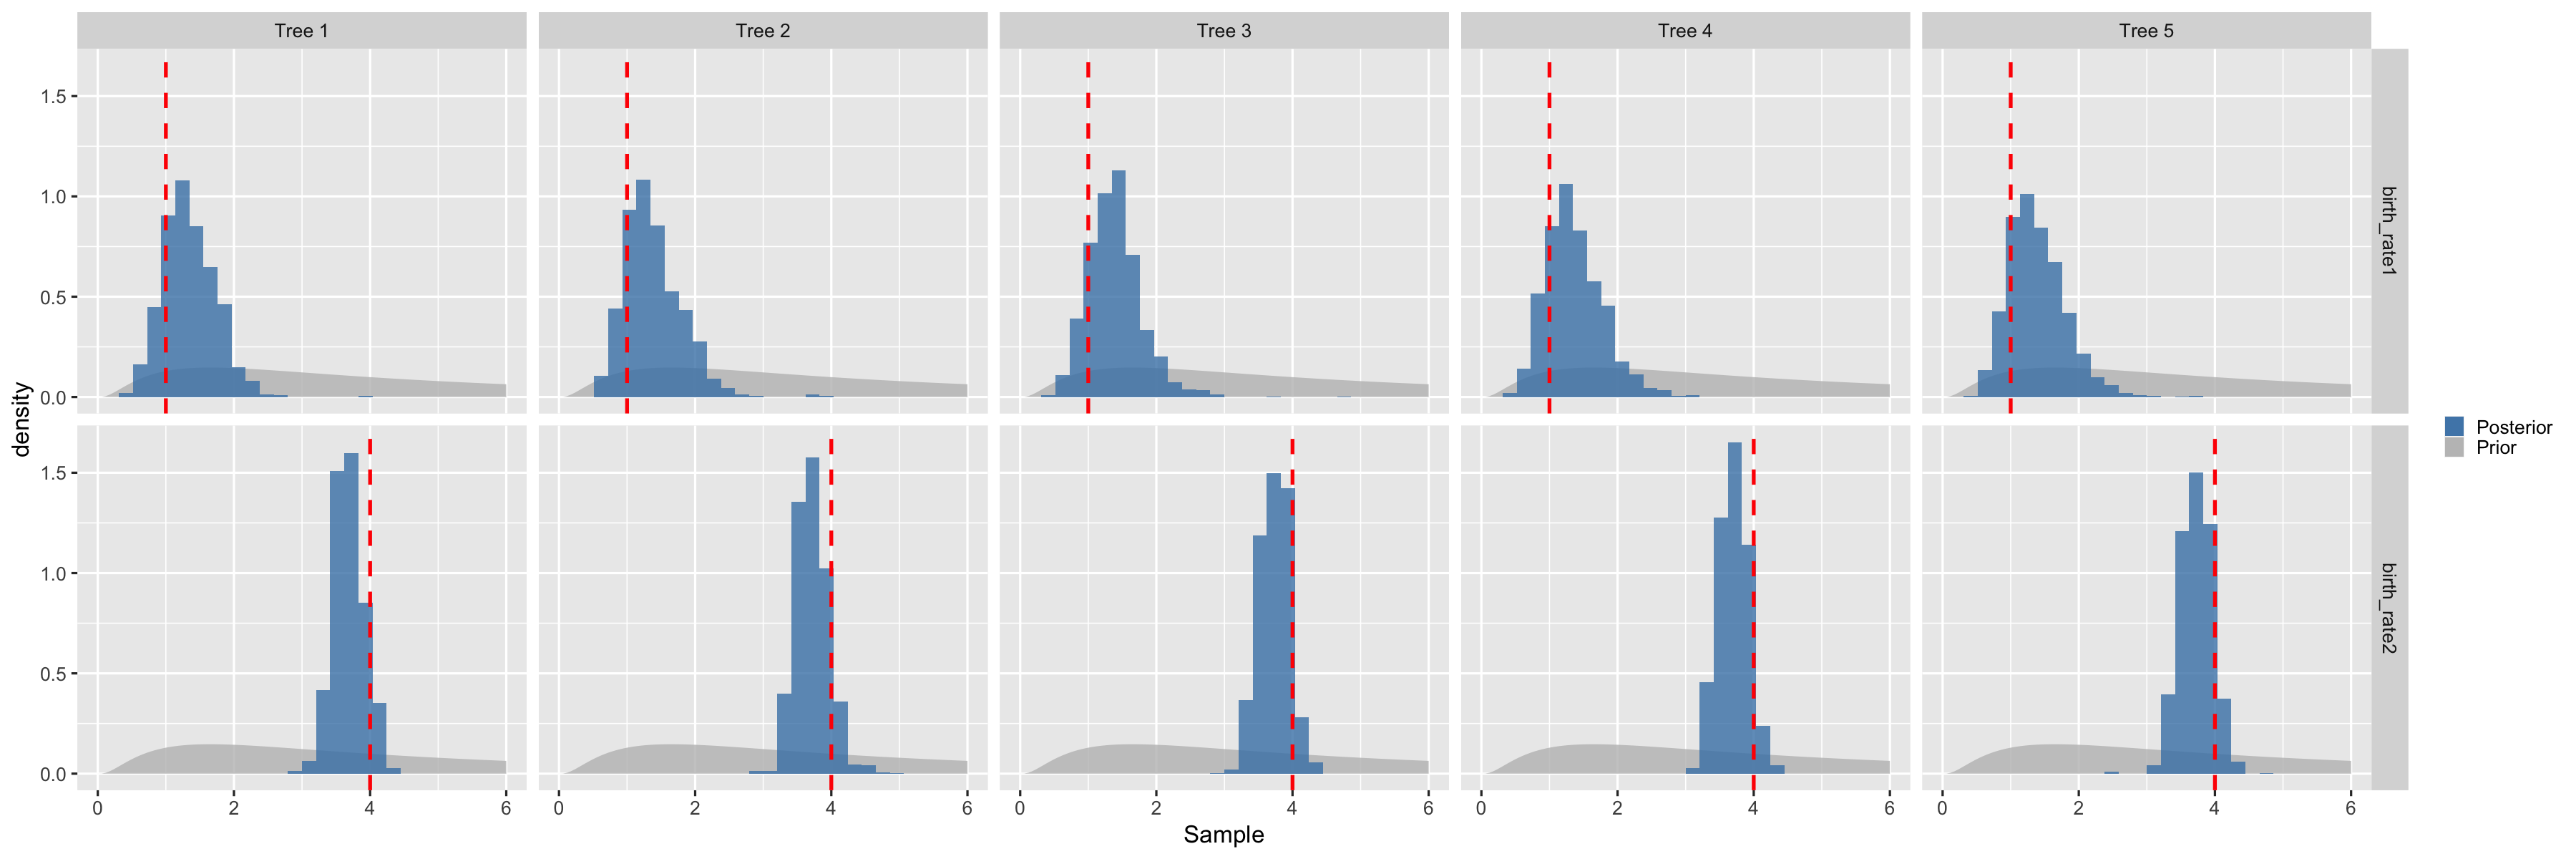

In [13]:
options(repr.plot.width = 30, repr.plot.height = 10)

left_join(samples, truth, by = "Parameter") |>
    filter(tree %in% 1:5) |>
    ggplot(aes(Sample)) +
    stat_function(
        aes(fill = "Prior"),
        fun = dlnorm,
        args = list(meanlog = 1.5, sdlog = 1),
        geom = "area",
        alpha = 0.8
    ) +
    geom_histogram(
        aes(y = after_stat(density), fill = "Posterior"),
        alpha = 0.8
    ) +
    geom_vline(aes(xintercept = Truth),
        color = "red",
        linewidth = 1.5,
        linetype = "dashed"
    ) +
    lims(x = c(0, 6)) +
    scale_fill_manual(
        name = "",
        values = c("Prior" = "grey", "Posterior" = "steelblue")
    ) +
    facet_grid(Parameter ~ paste("Tree", tree))
